# SA Score Distribution Analysis: Chemical vs. Biological Building Blocks

This notebook analyzes the distribution of Synthetic Accessibility (SA) scores between:
1. **Chemical building blocks** - from Enamine's building blocks catalog
2. **Biological metabolites** - extracted from BRENDA, KEGG, and MetaCyc databases

The goal is to determine if there exists a bias in the SA score when evaluating the synthesizability of biological metabolites vs. chemical building blocks.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import SA score calculator
from rdkit.Contrib.SA_Score import sascorer

# Matplotlib styling
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.autolayout'] = True
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.grid'] = False

## 1. Load Chemical Building Blocks

In [12]:
# Load chemical building blocks SMILES
chem_bb_path = Path('../data/processed/chemical_building_blocks.txt')

with open(chem_bb_path, 'r') as f:
    chemical_smiles = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(chemical_smiles)} chemical building blocks")
print(f"\nExample SMILES:")
for smi in chemical_smiles[:5]:
    print(f"  {smi}")

Loaded 278779 chemical building blocks

Example SMILES:
  CCOc1cc(C=O)ccc1OC(C)C(=O)N(C)C
  COc1cc(C=O)ccc1OCC(=O)c1ccc(Cl)c(Cl)c1
  Cn1c(NCCO)nc2ccccc21
  COc1cc(Cl)ccc1C(=O)O
  CC(=O)Oc1ccc(CC(C(=O)O)N2C(=O)c3ccccc3C2=O)cc1


## 2. Load Biological Metabolites from BKM Databases

Extract all unique metabolites from BRENDA, KEGG, and MetaCyc reaction databases.

In [13]:
def extract_metabolites_from_reactions(reaction_smiles_list):
    """
    Extract all unique metabolites from reaction SMILES.
    Reactions are in the format: A.B>>C.D
    """
    metabolites = set()
    
    for rxn in reaction_smiles_list:
        if pd.isna(rxn) or not isinstance(rxn, str):
            continue
        
        # Split reaction into reactants and products
        if '>>' in rxn:
            reactants_str, products_str = rxn.split('>>')
            
            # Split by '.' to get individual molecules
            reactants = reactants_str.split('.')
            products = products_str.split('.')
            
            # Add all molecules
            for mol_smiles in reactants + products:
                mol_smiles = mol_smiles.strip()
                if mol_smiles:
                    metabolites.add(mol_smiles)
    
    return metabolites

# Load all BKM databases
bkm_path = Path('../data/BKM_reactions')
databases = {
    'BRENDA': 'enzymemap_BRENDA_JN_mapped_non_unique.parquet',
    'KEGG': 'enzymemap_KEGG_JN_mapped_non_unique.parquet',
    'MetaCyc': 'enzymemap_MetaCyc_JN_mapped_non_unique.parquet'
}

all_biological_metabolites = set()
db_metabolite_counts = {}

for db_name, filename in databases.items():
    filepath = bkm_path / filename
    print(f"Loading {db_name}...")
    
    df = pd.read_parquet(filepath)
    print(f"  {len(df)} reactions")
    
    # Extract metabolites from unmapped reactions (cleaner SMILES)
    metabolites = extract_metabolites_from_reactions(df['unmapped'].tolist())
    db_metabolite_counts[db_name] = len(metabolites)
    all_biological_metabolites.update(metabolites)
    
    print(f"  {len(metabolites)} unique metabolites extracted")

print(f"\n" + "="*50)
print(f"Total unique biological metabolites: {len(all_biological_metabolites)}")

Loading BRENDA...
  42682 reactions
  39988 unique metabolites extracted
Loading KEGG...
  7966 reactions
  6063 unique metabolites extracted
Loading MetaCyc...
  4580 reactions
  4574 unique metabolites extracted

Total unique biological metabolites: 44719


## 3. Calculate SA Scores

In [14]:
def calculate_sa_scores(smiles_list, label="molecules"):
    """
    Calculate SA scores for a list of SMILES.
    Returns list of (smiles, sa_score) tuples for valid molecules.
    """
    results = []
    invalid_count = 0
    
    for i, smiles in enumerate(smiles_list):
        if i % 10000 == 0 and i > 0:
            print(f"  Processed {i}/{len(smiles_list)} {label}...")
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                sa_score = sascorer.calculateScore(mol)
                results.append((smiles, sa_score))
            else:
                invalid_count += 1
        except Exception as e:
            invalid_count += 1
    
    print(f"  Calculated SA scores for {len(results)} valid {label}")
    if invalid_count > 0:
        print(f"  Skipped {invalid_count} invalid SMILES")
    
    return results

print("Calculating SA scores for chemical building blocks...")
chemical_sa_results = calculate_sa_scores(chemical_smiles, "chemical building blocks")

print("\nCalculating SA scores for biological metabolites...")
biological_sa_results = calculate_sa_scores(list(all_biological_metabolites), "biological metabolites")

Calculating SA scores for chemical building blocks...
  Processed 10000/278779 chemical building blocks...
  Processed 20000/278779 chemical building blocks...
  Processed 30000/278779 chemical building blocks...
  Processed 40000/278779 chemical building blocks...
  Processed 50000/278779 chemical building blocks...
  Processed 60000/278779 chemical building blocks...
  Processed 70000/278779 chemical building blocks...
  Processed 80000/278779 chemical building blocks...
  Processed 90000/278779 chemical building blocks...
  Processed 100000/278779 chemical building blocks...
  Processed 110000/278779 chemical building blocks...
  Processed 120000/278779 chemical building blocks...
  Processed 130000/278779 chemical building blocks...
  Processed 140000/278779 chemical building blocks...
  Processed 150000/278779 chemical building blocks...
  Processed 160000/278779 chemical building blocks...
  Processed 170000/278779 chemical building blocks...
  Processed 180000/278779 chemical bu

[00:37:21] WARNING: not removing hydrogen atom without neighbors


  Processed 220000/278779 chemical building blocks...
  Processed 230000/278779 chemical building blocks...
  Processed 240000/278779 chemical building blocks...
  Processed 250000/278779 chemical building blocks...
  Processed 260000/278779 chemical building blocks...
  Processed 270000/278779 chemical building blocks...


[00:38:21] WARNING: not removing hydrogen atom without neighbors


  Calculated SA scores for 278779 valid chemical building blocks

Calculating SA scores for biological metabolites...
  Processed 10000/44719 biological metabolites...
  Processed 20000/44719 biological metabolites...
  Processed 30000/44719 biological metabolites...
  Processed 40000/44719 biological metabolites...


[00:39:21] WARNING: not removing hydrogen atom without neighbors


  Calculated SA scores for 44719 valid biological metabolites


In [15]:
# Extract just the SA scores
chemical_sa_scores = [score for _, score in chemical_sa_results]
biological_sa_scores = [score for _, score in biological_sa_results]

print(f"Chemical building blocks: n = {len(chemical_sa_scores)}")
print(f"Biological metabolites: n = {len(biological_sa_scores)}")

Chemical building blocks: n = 278779
Biological metabolites: n = 44719


## 4. Summary Statistics

In [16]:
# Calculate summary statistics
def summarize_distribution(scores, label):
    scores = np.array(scores)
    print(f"\n{label}:")
    print(f"  n = {len(scores)}")
    print(f"  Mean: {np.mean(scores):.3f}")
    print(f"  Median: {np.median(scores):.3f}")
    print(f"  Std Dev: {np.std(scores):.3f}")
    print(f"  Min: {np.min(scores):.3f}")
    print(f"  Max: {np.max(scores):.3f}")
    print(f"  25th percentile: {np.percentile(scores, 25):.3f}")
    print(f"  75th percentile: {np.percentile(scores, 75):.3f}")
    return {
        'n': len(scores),
        'mean': np.mean(scores),
        'median': np.median(scores),
        'std': np.std(scores),
        'min': np.min(scores),
        'max': np.max(scores),
        'q25': np.percentile(scores, 25),
        'q75': np.percentile(scores, 75)
    }

print("="*60)
print("SA SCORE DISTRIBUTION SUMMARY")
print("="*60)

chem_stats = summarize_distribution(chemical_sa_scores, "Chemical Building Blocks")
bio_stats = summarize_distribution(biological_sa_scores, "Biological Metabolites")

SA SCORE DISTRIBUTION SUMMARY

Chemical Building Blocks:
  n = 278779
  Mean: 2.715
  Median: 2.604
  Std Dev: 0.694
  Min: 1.000
  Max: 8.618
  25th percentile: 2.212
  75th percentile: 3.097

Biological Metabolites:
  n = 44719
  Mean: 3.880
  Median: 3.746
  Std Dev: 1.338
  Min: 1.000
  Max: 10.000
  25th percentile: 2.888
  75th percentile: 4.713


## 5. Visualize Distributions

Figure saved to: ../figures/SA_score_distribution_comparison.png


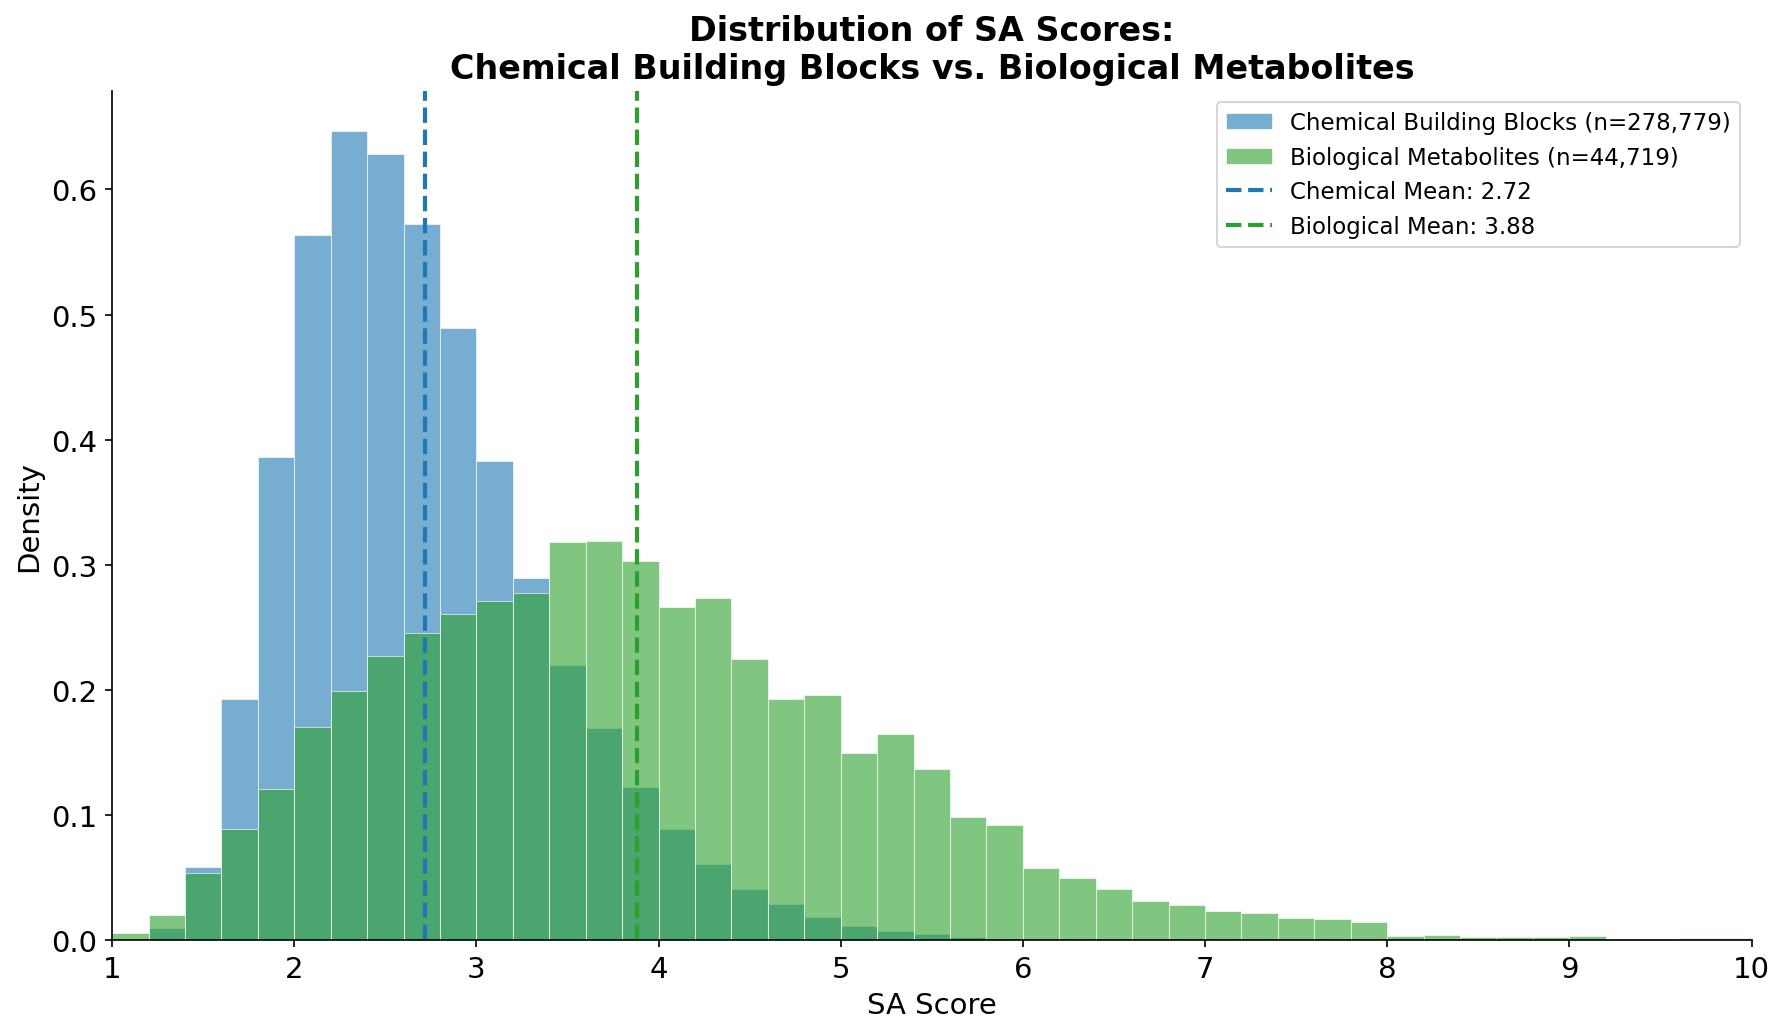

In [17]:
# Create figure with overlaid histograms
fig, ax = plt.subplots(figsize=(12, 7))

# Define bin edges for consistent comparison
bins = np.linspace(1, 10, 46)  # SA scores typically range from 1-10

# Plot histograms with transparency
ax.hist(chemical_sa_scores, bins=bins, alpha=0.6, label=f'Chemical Building Blocks (n={len(chemical_sa_scores):,})',
        color='#1f77b4', edgecolor='white', linewidth=0.5, density=True)
ax.hist(biological_sa_scores, bins=bins, alpha=0.6, label=f'Biological Metabolites (n={len(biological_sa_scores):,})',
        color='#2ca02c', edgecolor='white', linewidth=0.5, density=True)

# Add vertical lines for means
ax.axvline(chem_stats['mean'], color='#1f77b4', linestyle='--', linewidth=2, 
           label=f'Chemical Mean: {chem_stats["mean"]:.2f}')
ax.axvline(bio_stats['mean'], color='#2ca02c', linestyle='--', linewidth=2,
           label=f'Biological Mean: {bio_stats["mean"]:.2f}')

# Formatting
ax.set_xlabel('SA Score', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_title('Distribution of SA Scores:\nChemical Building Blocks vs. Biological Metabolites', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim(1, 10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)
save_path = figures_dir / 'SA_score_distribution_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

Figure saved to: ../figures/SA_score_boxplot_comparison.png


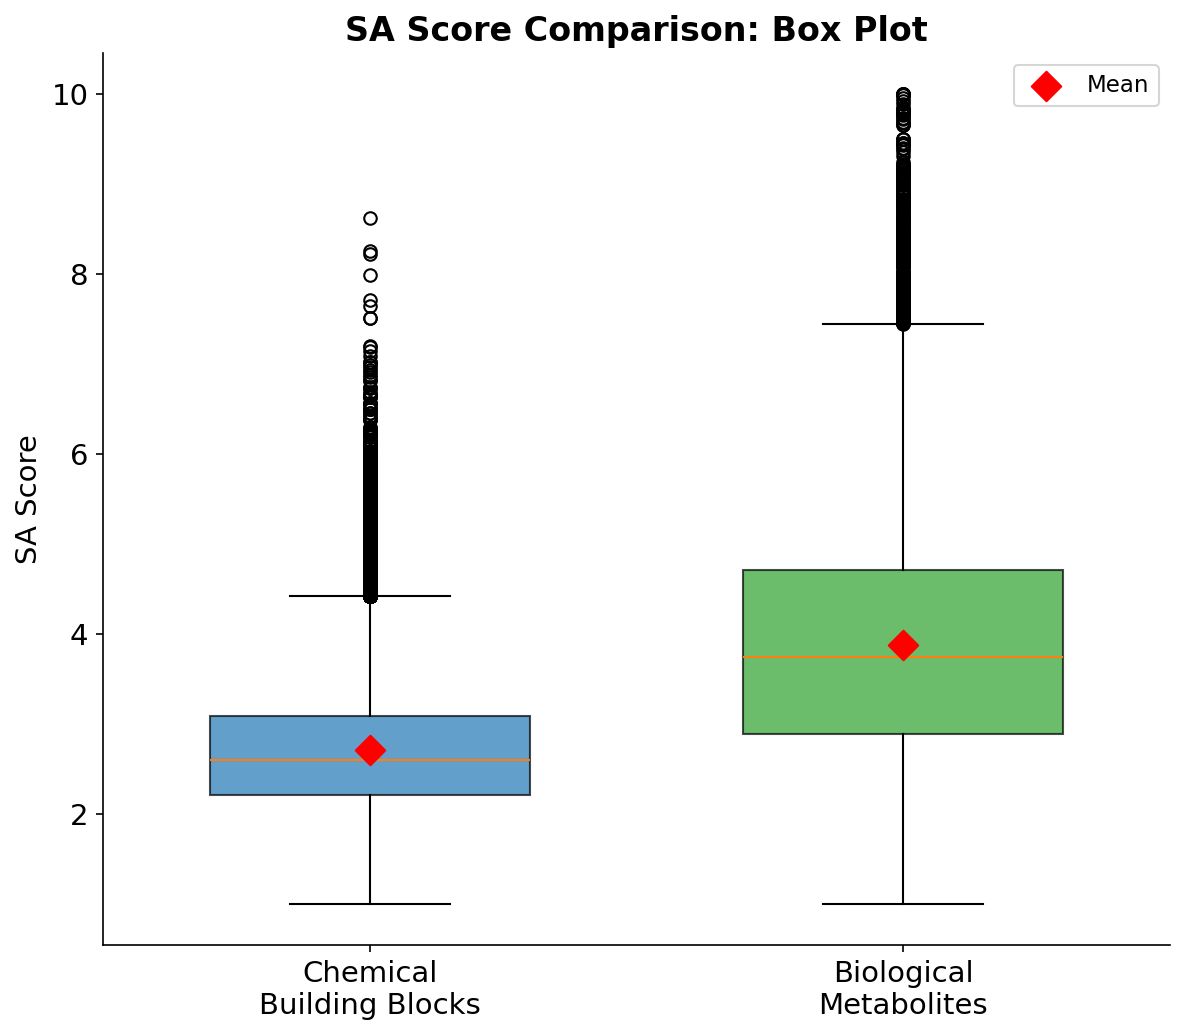

In [18]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 7))

data = [chemical_sa_scores, biological_sa_scores]
labels = ['Chemical\nBuilding Blocks', 'Biological\nMetabolites']
colors = ['#1f77b4', '#2ca02c']

bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Formatting
ax.set_ylabel('SA Score', fontsize=14)
ax.set_title('SA Score Comparison: Box Plot', fontsize=16, fontweight='bold')

# Add mean markers
means = [chem_stats['mean'], bio_stats['mean']]
ax.scatter([1, 2], means, color='red', marker='D', s=100, zorder=3, label='Mean')

ax.legend(loc='upper right', fontsize=11)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'SA_score_boxplot_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 6. Statistical Significance Test

In [19]:
from scipy import stats

# Mann-Whitney U test (non-parametric test for comparing distributions)
statistic, p_value = stats.mannwhitneyu(chemical_sa_scores, biological_sa_scores, alternative='two-sided')

print("="*60)
print("STATISTICAL SIGNIFICANCE TEST")
print("="*60)
print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {statistic:,.0f}")
print(f"  p-value: {p_value:.2e}")

if p_value < 0.001:
    print(f"\n  *** Highly significant difference (p < 0.001) ***")
elif p_value < 0.01:
    print(f"\n  ** Significant difference (p < 0.01) **")
elif p_value < 0.05:
    print(f"\n  * Significant difference (p < 0.05) *")
else:
    print(f"\n  No significant difference (p >= 0.05)")

# Effect size (Cohen's d)
cohens_d = (np.mean(chemical_sa_scores) - np.mean(biological_sa_scores)) / \
           np.sqrt((np.std(chemical_sa_scores)**2 + np.std(biological_sa_scores)**2) / 2)

print(f"\nEffect Size (Cohen's d): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print("  Interpretation: Negligible effect")
elif abs(cohens_d) < 0.5:
    print("  Interpretation: Small effect")
elif abs(cohens_d) < 0.8:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

STATISTICAL SIGNIFICANCE TEST

Mann-Whitney U Test:
  U-statistic: 2,782,555,720
  p-value: 0.00e+00

  *** Highly significant difference (p < 0.001) ***

Effect Size (Cohen's d): -1.093
  Interpretation: Large effect


## 7. Summary Table

In [20]:
# Create summary comparison table
summary_df = pd.DataFrame({
    'Metric': ['Count', 'Mean SA Score', 'Median SA Score', 'Std Dev', 'Min', 'Max', '25th Percentile', '75th Percentile'],
    'Chemical Building Blocks': [
        f"{chem_stats['n']:,}",
        f"{chem_stats['mean']:.3f}",
        f"{chem_stats['median']:.3f}",
        f"{chem_stats['std']:.3f}",
        f"{chem_stats['min']:.3f}",
        f"{chem_stats['max']:.3f}",
        f"{chem_stats['q25']:.3f}",
        f"{chem_stats['q75']:.3f}"
    ],
    'Biological Metabolites': [
        f"{bio_stats['n']:,}",
        f"{bio_stats['mean']:.3f}",
        f"{bio_stats['median']:.3f}",
        f"{bio_stats['std']:.3f}",
        f"{bio_stats['min']:.3f}",
        f"{bio_stats['max']:.3f}",
        f"{bio_stats['q25']:.3f}",
        f"{bio_stats['q75']:.3f}"
    ]
})

print("\n" + "="*60)
print("SUMMARY COMPARISON TABLE")
print("="*60)
display(summary_df)


SUMMARY COMPARISON TABLE


,Metric,Chemical Building Blocks,Biological Metabolites
0,Count,"278,779","44,719"
1,Mean SA Score,2.715,3.880
2,Median SA Score,2.604,3.746
3,Std Dev,0.694,1.338
4,Min,1.000,1.000
5,Max,8.618,10.000
6,25th Percentile,2.212,2.888
7,75th Percentile,3.097,4.713


## 8. Load PKS Building Blocks

Load the expanded PKS (polyketide synthase) building blocks library for comparison with chemical building blocks.

In [21]:
# Load PKS building blocks SMILES
pks_bb_path = Path('../data/processed/expanded_PKS_SMILES_V3.txt')

with open(pks_bb_path, 'r') as f:
    pks_smiles = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(pks_smiles):,} PKS building blocks")
print(f"\nExample SMILES:")
for smi in pks_smiles[:5]:
    print(f"  {smi}")

Loaded 961,986 PKS building blocks

Example SMILES:
  C=CCC(C(=O)O)C(=O)CC
  CCC(=O)C(CC)C(=O)O
  CCC(=O)CC(=O)O
  CCCC(CC)C(=O)O
  C=CCC(C(=O)O)C(O)CC


## 9. Calculate SA Scores for PKS Building Blocks

In [22]:
print("Calculating SA scores for PKS building blocks...")
pks_sa_results = calculate_sa_scores(pks_smiles, "PKS building blocks")

# Extract just the SA scores
pks_sa_scores = [score for _, score in pks_sa_results]

print(f"\nPKS building blocks with valid SA scores: n = {len(pks_sa_scores):,}")

Calculating SA scores for PKS building blocks...
  Processed 10000/961986 PKS building blocks...
  Processed 20000/961986 PKS building blocks...
  Processed 30000/961986 PKS building blocks...
  Processed 40000/961986 PKS building blocks...
  Processed 50000/961986 PKS building blocks...
  Processed 60000/961986 PKS building blocks...
  Processed 70000/961986 PKS building blocks...
  Processed 80000/961986 PKS building blocks...
  Processed 90000/961986 PKS building blocks...
  Processed 100000/961986 PKS building blocks...
  Processed 110000/961986 PKS building blocks...
  Processed 120000/961986 PKS building blocks...
  Processed 130000/961986 PKS building blocks...
  Processed 140000/961986 PKS building blocks...
  Processed 150000/961986 PKS building blocks...
  Processed 160000/961986 PKS building blocks...
  Processed 170000/961986 PKS building blocks...
  Processed 180000/961986 PKS building blocks...
  Processed 190000/961986 PKS building blocks...
  Processed 200000/961986 PKS

## 10. PKS Summary Statistics

In [23]:
print("="*60)
print("PKS BUILDING BLOCKS SA SCORE SUMMARY")
print("="*60)

pks_stats = summarize_distribution(pks_sa_scores, "PKS Building Blocks")

PKS BUILDING BLOCKS SA SCORE SUMMARY

PKS Building Blocks:
  n = 961986
  Mean: 4.312
  Median: 4.280
  Std Dev: 0.601
  Min: 1.227
  Max: 6.492
  25th percentile: 3.934
  75th percentile: 4.624


## 11. Visualize Chemical vs. PKS Distributions

Figure saved to: ../figures/SA_score_chemical_vs_pks.png


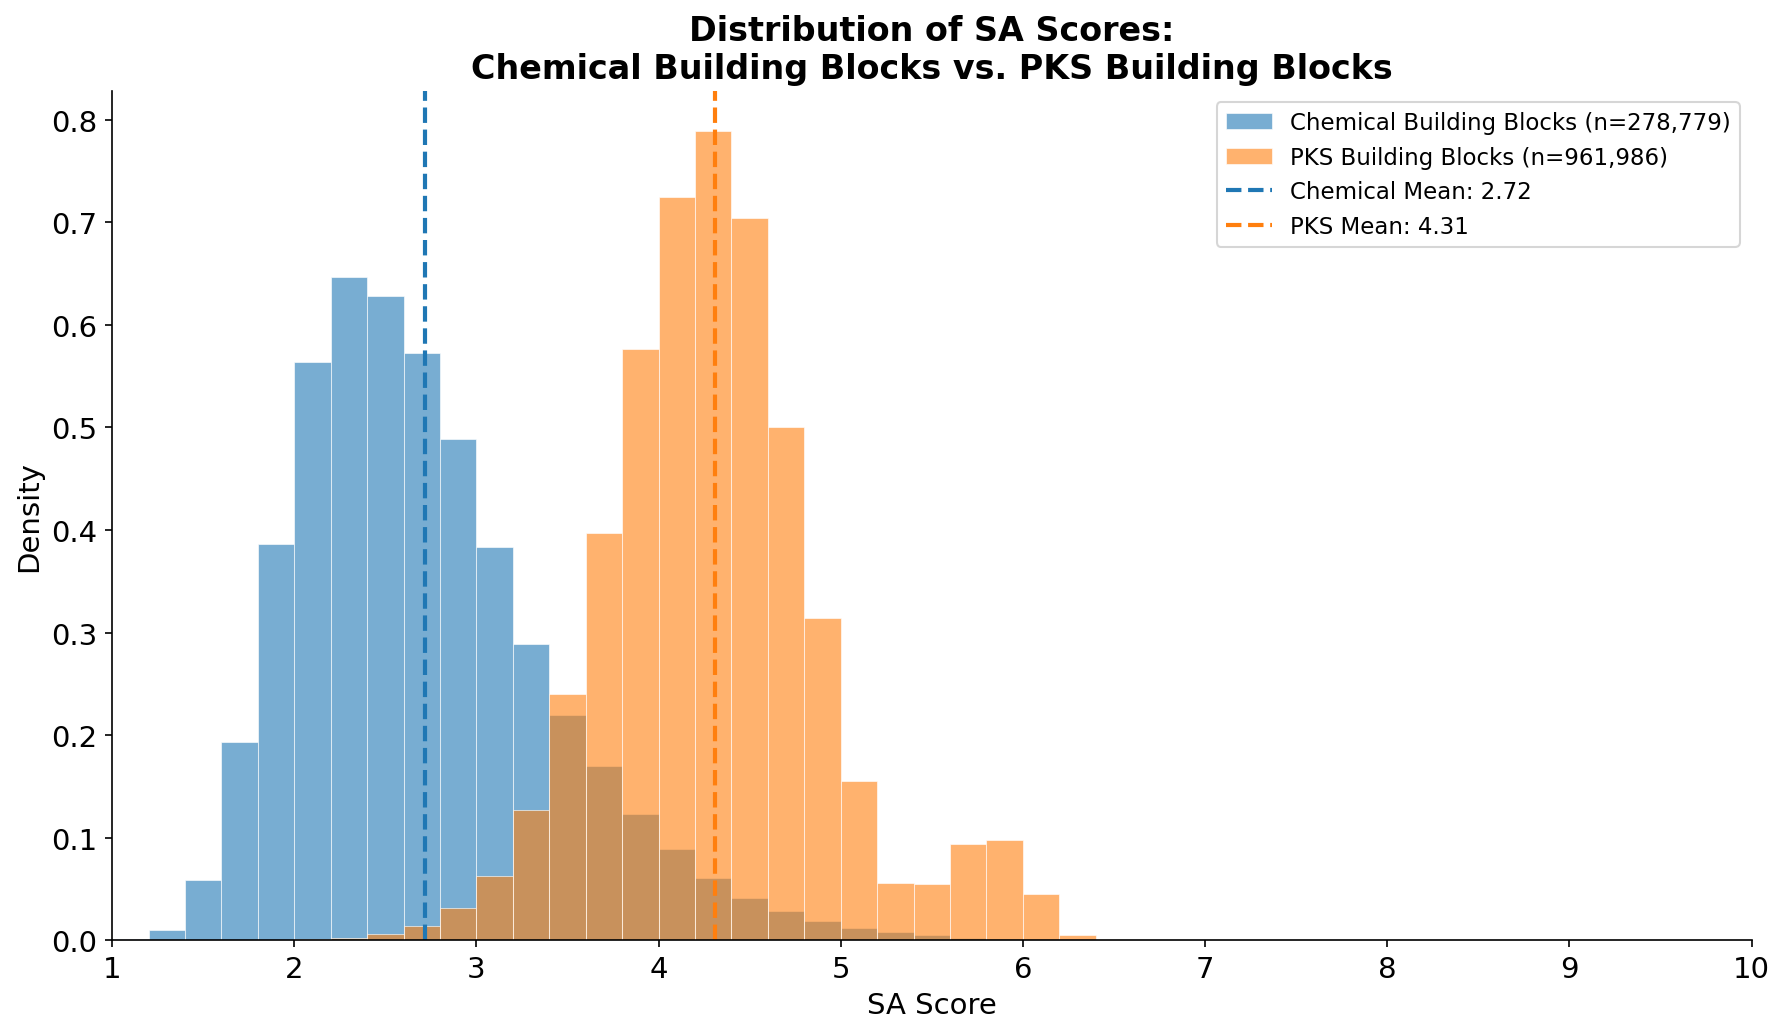

In [24]:
# Create figure with overlaid histograms for Chemical vs. PKS
fig, ax = plt.subplots(figsize=(12, 7))

# Define bin edges for consistent comparison
bins = np.linspace(1, 10, 46)  # SA scores typically range from 1-10

# Plot histograms with transparency
ax.hist(chemical_sa_scores, bins=bins, alpha=0.6, label=f'Chemical Building Blocks (n={len(chemical_sa_scores):,})',
        color='#1f77b4', edgecolor='white', linewidth=0.5, density=True)
ax.hist(pks_sa_scores, bins=bins, alpha=0.6, label=f'PKS Building Blocks (n={len(pks_sa_scores):,})',
        color='#ff7f0e', edgecolor='white', linewidth=0.5, density=True)

# Add vertical lines for means
ax.axvline(chem_stats['mean'], color='#1f77b4', linestyle='--', linewidth=2, 
           label=f'Chemical Mean: {chem_stats["mean"]:.2f}')
ax.axvline(pks_stats['mean'], color='#ff7f0e', linestyle='--', linewidth=2,
           label=f'PKS Mean: {pks_stats["mean"]:.2f}')

# Formatting
ax.set_xlabel('SA Score', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_title('Distribution of SA Scores:\nChemical Building Blocks vs. PKS Building Blocks', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim(1, 10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
save_path = figures_dir / 'SA_score_chemical_vs_pks.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 12. Box Plot Comparison (Chemical vs. PKS)

Figure saved to: ../figures/SA_score_boxplot_chemical_vs_pks.png


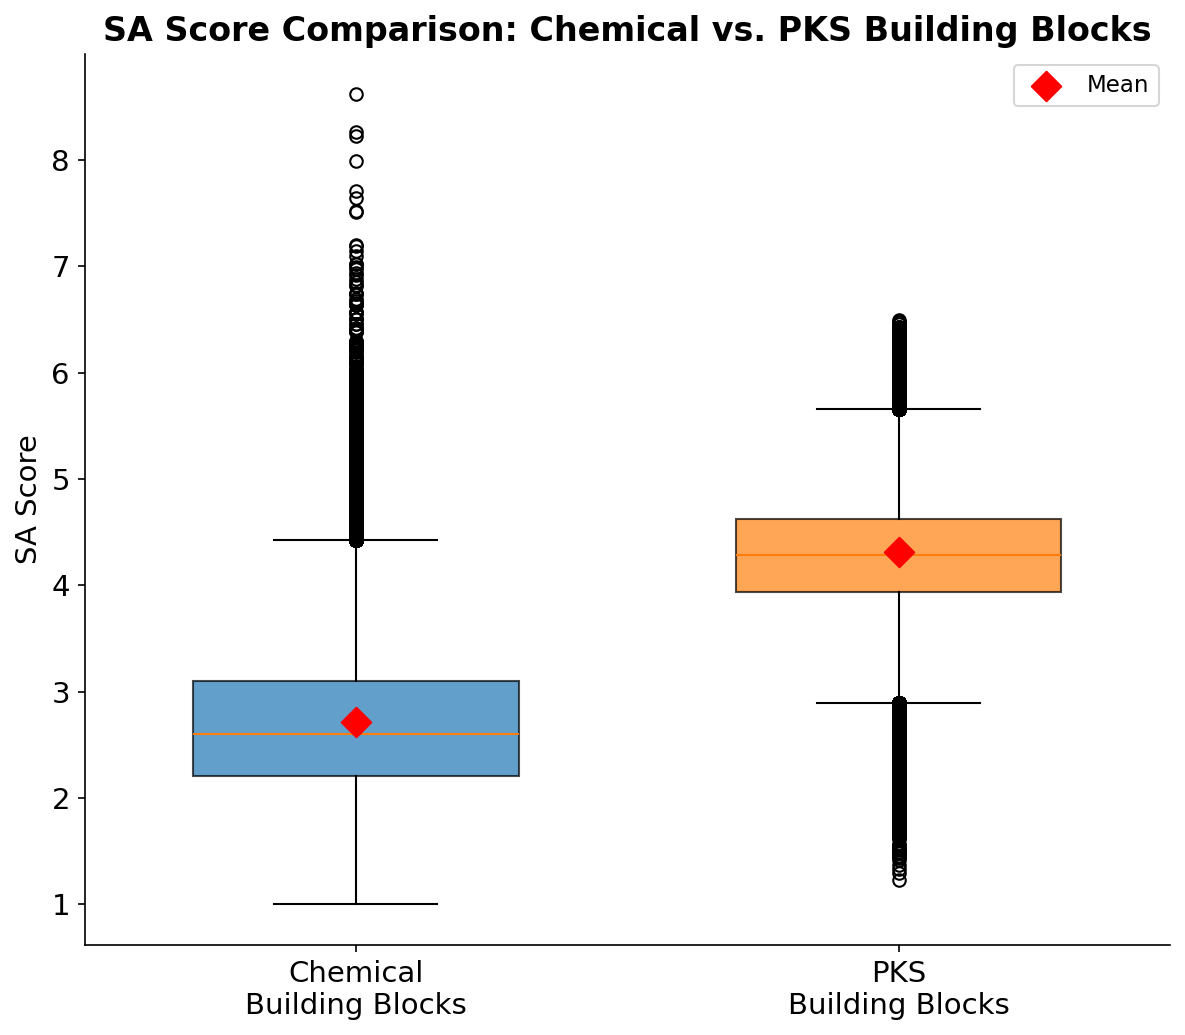

In [25]:
# Box plot comparison for Chemical vs. PKS
fig, ax = plt.subplots(figsize=(8, 7))

data = [chemical_sa_scores, pks_sa_scores]
labels = ['Chemical\nBuilding Blocks', 'PKS\nBuilding Blocks']
colors = ['#1f77b4', '#ff7f0e']

bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Formatting
ax.set_ylabel('SA Score', fontsize=14)
ax.set_title('SA Score Comparison: Chemical vs. PKS Building Blocks', fontsize=16, fontweight='bold')

# Add mean markers
means = [chem_stats['mean'], pks_stats['mean']]
ax.scatter([1, 2], means, color='red', marker='D', s=100, zorder=3, label='Mean')

ax.legend(loc='upper right', fontsize=11)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'SA_score_boxplot_chemical_vs_pks.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 13. Statistical Significance Test (Chemical vs. PKS)

In [26]:
# Mann-Whitney U test for Chemical vs. PKS
statistic_pks, p_value_pks = stats.mannwhitneyu(chemical_sa_scores, pks_sa_scores, alternative='two-sided')

print("="*60)
print("STATISTICAL SIGNIFICANCE TEST: Chemical vs. PKS")
print("="*60)
print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {statistic_pks:,.0f}")
print(f"  p-value: {p_value_pks:.2e}")

if p_value_pks < 0.001:
    print(f"\n  *** Highly significant difference (p < 0.001) ***")
elif p_value_pks < 0.01:
    print(f"\n  ** Significant difference (p < 0.01) **")
elif p_value_pks < 0.05:
    print(f"\n  * Significant difference (p < 0.05) *")
else:
    print(f"\n  No significant difference (p >= 0.05)")

# Effect size (Cohen's d)
cohens_d_pks = (np.mean(chemical_sa_scores) - np.mean(pks_sa_scores)) / \
               np.sqrt((np.std(chemical_sa_scores)**2 + np.std(pks_sa_scores)**2) / 2)

print(f"\nEffect Size (Cohen's d): {cohens_d_pks:.3f}")
if abs(cohens_d_pks) < 0.2:
    print("  Interpretation: Negligible effect")
elif abs(cohens_d_pks) < 0.5:
    print("  Interpretation: Small effect")
elif abs(cohens_d_pks) < 0.8:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

STATISTICAL SIGNIFICANCE TEST: Chemical vs. PKS

Mann-Whitney U Test:
  U-statistic: 13,087,464,118
  p-value: 0.00e+00

  *** Highly significant difference (p < 0.001) ***

Effect Size (Cohen's d): -2.459
  Interpretation: Large effect


## 14. Summary Table (Chemical vs. PKS)

In [ ]:
# Create summary comparison table for Chemical vs. PKS
summary_pks_df = pd.DataFrame({
    'Metric': ['Count', 'Mean SA Score', 'Median SA Score', 'Std Dev', 'Min', 'Max', '25th Percentile', '75th Percentile'],
    'Chemical Building Blocks': [
        f"{chem_stats['n']:,}",
        f"{chem_stats['mean']:.3f}",
        f"{chem_stats['median']:.3f}",
        f"{chem_stats['std']:.3f}",
        f"{chem_stats['min']:.3f}",
        f"{chem_stats['max']:.3f}",
        f"{chem_stats['q25']:.3f}",
        f"{chem_stats['q75']:.3f}"
    ],
    'PKS Building Blocks': [
        f"{pks_stats['n']:,}",
        f"{pks_stats['mean']:.3f}",
        f"{pks_stats['median']:.3f}",
        f"{pks_stats['std']:.3f}",
        f"{pks_stats['min']:.3f}",
        f"{pks_stats['max']:.3f}",
        f"{pks_stats['q25']:.3f}",
        f"{pks_stats['q75']:.3f}"
    ]
})

print("\n" + "="*60)
print("SUMMARY COMPARISON TABLE: Chemical vs. PKS")
print("="*60)
display(summary_pks_df)